# Phylogenetic analysis of complete *E. coli* genomes

------

In this notebook we will reconstruct approximate phylogeny of all fully sequenced *E. coli* genomes

In [39]:
# Make sure cells are full width of the screen

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import necessary libraries

import pandas as pd
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import matplotlib
import matplotlib.pyplot as plt

import Bio
import Bio.Phylo.TreeConstruction as tc
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo

from ete3 import Tree, TreeStyle, NodeStyle, TextFace, faces, AttrFace

### First, we will process result of megablast analysis. 

The data was generated with the following command in Galaxy:

`blastn -query ecoli_genomes_only.fna -db ecg -outfmt "6 qaccver saccver pident length mismatch gapopen qstart qend qlen sstart send slen" -max_hsps 2 -max_target_seqs 2 -num_threads 8 > blast.tab `

**Note** that this is a **non standard** list of output fields! 

The resulting file is enormous as it contains many small alignemnts and large amount of self hits. Below we get rid of those.

In [2]:
# Create two filtered down files

# !cat blast.tab | awk '$1!=$2 && $4 > 10000' > blast_10K.tab
# !cat blast_10K.tab | awk '$1!=$2 && $4 > 100000' > blast_100K.tab


First, we will read megablast output into a dataframe called `bl` (for blast):

In [3]:
# Read data in and name columns
bl = pd.read_table("blast_100K.tab",names=['q','t','id','len','mism','gap','qstart','qend','qlen','tstart','tend','tlen'])

Let's take a look at the data:

In [4]:
bl.head()

,q,t,id,len,mism,gap,qstart,qend,qlen,tstart,tend,tlen
0,U00096.3,CP012868.1,100.000,4641667,1,7,1,4641652,4641652,4641665,1,4641665
1,U00096.3,CP012869.1,99.999,4641686,3,10,1,4641652,4641652,4641684,1,4641684
2,U00096.3,CP012870.1,99.999,4641691,3,12,1,4641652,4641652,4641689,1,4641689
3,U00096.3,CP026028.1,100.000,3340961,2,4,1300694,4641652,4641652,1298718,4639673,4639673
4,U00096.3,CP026028.1,100.000,1040823,1,1,258676,1299498,4641652,257900,1298721,4639673


Next, we will group blast results by query (`q`) and target (`t`) names and for each unique query/targer combination we will compute:

 - minimum genomes length (`min(qlen,tlen) as len`)
 - total length of alignemnt blocks (`sum(len) as align_len`)
 
The result will be stored in dataframe `bl_max_align_len`:

In [5]:
# Group by target/query combination and compute sum of alignments for each combination and minimum genome length (e.g., min(q,t)). 
bl_max_align_len = pysqldf("select q, t, min(qlen,tlen) as len, sum(len) as align_len from bl group by q, t")

Let's see the distribution of genome length (`len`) and total alignment length (`align_len`):

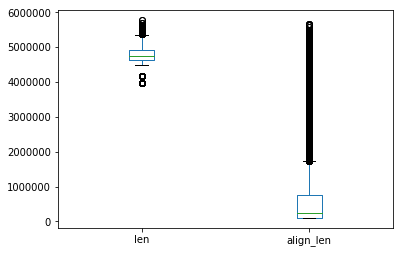

In [6]:
%matplotlib inline 
bl_max_align_len.plot.box()

You can see that the majority of `align_len` values are low with median somewhere below 50,000 bp. This majority of *E. coli* strains in this dataset are likely only remotely related to each other. 

Let's compute a measure called alignable length $L_a$:

$$L_a = \frac{Length_{alignments}}{min(Length_{query}, Length_{target})}$$

In [7]:
La = pysqldf("select q, t, align_len, len, cast (align_len as float)/len as La from bl_max_align_len")

Plotting $L_a$ shows that there a few outliers where $L_a > 1$:

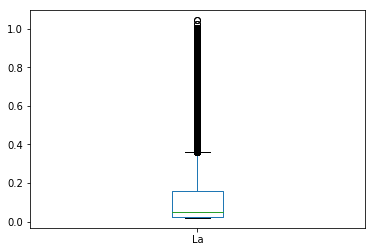

In [8]:
La['La'].plot.box()

This is because in highly similar strains there may be a single alignment across the entire genome plus additional alignements of duplicated or otherwise highly similar reagions. This is a problem however, because ultimately the measure of how two strains are similar to each other will be $1 - L_a$, which will be negative for all cases where $L_a > 1$. To solve this problem will will cap $L_a$ at 1:

In [9]:
La = pysqldf("select q, t, align_len, len, min(La, 1) as La from La")

Now $L_a \leq 1$:

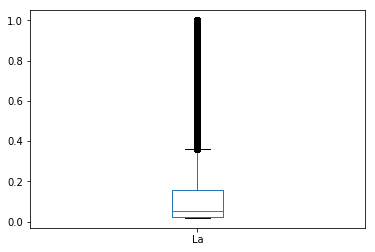

In [10]:
La['La'].plot.box()

Now that the $L_a$ is capped at 1, let's convert it into a proper distance by computing distance $D = 1- L_a$:

In [11]:
dist = pysqldf("select q, t, align_len, len, 1 - La as D from La")

As we've predicted above most strains are relatively far from each other with median $D$ somewhere above 0.9:

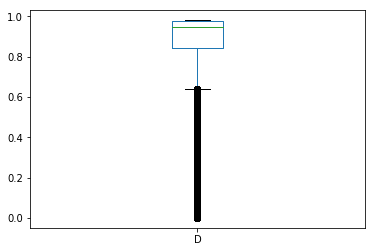

In [12]:
dist['D'].plot.box()

## Converting distance data into phylogenetic tree

------

Here we will convert list of distances into a pairwise distance matrix, perform clustering using [Neighbor-Joining method](https://academic.oup.com/mbe/article/4/4/406/1029664) and finally visualize the tree.

First, we will convert `dist` dataframe into `numpy` array, which will simplify our life downstream:

In [13]:
dist_as_array = dist[['q','t','D']].values

This array will contain pairwise distances:

In [14]:
dist_as_array[0][0:3]

array(['AE014075.1', 'AP009378.1', 0.9048204729023022], dtype=object)

Next, we will convert this array into a disctionary where accession numbers are used as "keys" to distance values:

In [15]:
# Convert numpy array to a dictionary where q ant are keys
dist_as_dict = {}
for row in dist_as_array:
    dist_as_dict[row[1]]={}
    dist_as_dict[row[0]]={}
    
for row in dist_as_array :
    dist_as_dict[row[1]][row[0]]=row[2]

For example, accession number `AE014075.1` is aligning against many other accessions with the following values of $D$:

In [16]:
dist_as_dict['AE014075.1']

{'AP009378.1': 0.90482026091834,
 'CP000247.1': 0.8185678245446373,
 'CP000468.1': 0.8048405901190963,
 'CP001671.1': 0.3346620813006672,
 'CP001855.1': 0.7364305589577025,
 'CP001969.1': 0.8362648219602955,
 'CP002167.1': 0.8169796473592198,
 'CP002211.1': 0.29029177200794065,
 'CP002212.1': 0.29029177200794065,
 'CP005930.1': 0.9001751047006817,
 'CP006784.1': 0.930065821458271,
 'CP006830.1': 0.8274326844257384,
 'CP007149.1': 0.8316949830156941,
 'CP007275.1': 0.8000899899475912,
 'CP007799.1': 0.48964814196047424,
 'CP009072.1': 0.3791435081733394,
 'CP010151.1': 0.867846271210292,
 'CP010876.1': 0.9284042496294067,
 'CP011915.1': 0.8247379218218895,
 'CP012379.1': 0.8104253661150395,
 'CP012625.1': 0.8337189534337235,
 'CP012631.1': 0.82502116712901,
 'CP012633.1': 0.8412290708011995,
 'CP012635.1': 0.8290066464708612,
 'CP013658.1': 0.9297470637375256,
 'CP013831.1': 0.954612321835492,
 'CP013835.1': 0.9322329580662534,
 'CP013837.1': 0.9515889428646908,
 'CP014316.1': 0.9293930

We can now use `pandas` functionality to convert this dictionary into a matrix like this:

\begin{bmatrix}
    D_{11}       & D_{12} & D_{13} & \dots & D_{1n} \\
    D_{21}       & D_{22} & D_{23} & \dots & D_{2n} \\
    \dots \\
    D_{d1}       & D_{d2} & D_{d3} & \dots & D_{dn}
\end{bmatrix}

While doing this we will fill missing values with `1` indicating the maximum distance between two genomes:

In [17]:
# Covert it to a matrix
D_matrix = pd.DataFrame(dist_as_dict).T.fillna(1)

It looks like this:

In [18]:
D_matrix.head()

,AE014075.1,AM946981.2,AP009048.1,AP009240.1,AP009378.1,AP010953.1,AP010960.1,AP012030.1,AP012306.1,AP017610.1,...,LM995446.1,LN832404.1,LT601384.1,LT615377.1,LT615378.1,LT838196.1,LT883142.1,LT903847.1,LT906474.1,U00096.3
AE014075.1,1.00000,1.000000,1.000000,1.000000,0.90482,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.949982,1.000000,1.000000
AM946981.2,1.00000,1.000000,0.974699,1.000000,1.00000,1.000000,1.000000,1.000000,0.972939,1.000000,...,0.974699,0.974699,0.970476,0.974699,0.974699,0.850059,0.885097,1.000000,0.911871,0.974699
AP009048.1,1.00000,0.974699,1.000000,0.969072,1.00000,0.977681,0.977681,0.172585,0.478005,0.977665,...,0.189135,0.179722,0.738840,0.179722,0.179723,0.673971,0.872128,1.000000,0.791710,0.043604
AP009240.1,1.00000,1.000000,0.969072,1.000000,1.00000,0.908196,0.898895,1.000000,0.964164,1.000000,...,0.968662,0.969017,1.000000,0.969017,0.969017,1.000000,1.000000,1.000000,1.000000,0.969041
AP009378.1,0.90482,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.978793,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we will convert values from this matrix to an array:

In [19]:
# Convert matrix (a dataframe) to an array
matrix = D_matrix.values.tolist()

And move names (accession numbers) to another array:

In [20]:
# Retrieve names
names = list(D_matrix.columns.values)

We now reformat the matrix so that only lower traingle is preserved:

\begin{bmatrix}
    D_{11}        \\
    D_{21}       & D_{22}  \\
    \dots \\
    D_{d1}       & D_{d2} & D_{d3} & \dots & D_{dn}
\end{bmatrix}

This is done with the following script:

In [21]:
# Convert matrix from a fill square into lower triangle
matrix_lt = []
for i, row in enumerate(matrix):
    matrix_lt.append(row[:(i+1)])

Now, let's convert the matrix into a Bio:Phylo distance matrix object and generate tree using Neightbor-Joining approach (this may take ~5min):

In [22]:
# Initialize Bio distance matrix using names and lower traingle
# Compute phylogenetic tree using NJ
dm = tc.DistanceMatrix(names, matrix_lt)
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

Write tree out as a Newick file:

In [23]:
Phylo.write(tree,'ecoli.nwk', 'newick')

1

Use `ETE3` library to read the tree from the Newick file created above and visualize it. The three strains most closely related to our assembly of *E. coli* C are highlighted in red: 

In [45]:
t = Tree("ecoli.nwk", format=1)


# Our strains
nst1 = NodeStyle()
n1 = t.get_common_ancestor("CP020543.1","LT906474.1","CP024090.1")
n1.set_style(nst1)
nst1["bgcolor"] = "Yellow"
# B1
nst2 = NodeStyle()
n2 = t.get_common_ancestor("CP002516.1","CP002185.1","AP010953.1","AP010953.1","AP009240.1","AP010960.1","CP002516.1","CP002185.1","CU928160.2","CU928145.2")
n2.set_style(nst2)
nst2["bgcolor"] = "LightCoral"
# A
nst3 = NodeStyle()
n3 = t.get_common_ancestor("U00096.3","CP000802.1","CP000946.1","CP001509.3","CP000819.1","CP001665.1","CP002729.1","CP001637.1","AP009048.1","CP001396.1","CP002291.1","FN649414.1")
n3.set_style(nst3)
nst3["bgcolor"] = "LightGreen"
# B2
nst4 = NodeStyle()
n4 = t.get_common_ancestor("CP002167.1","CP000468.1","CU928161.2","CP001969.1","CP001671.1","AE014075.1","CP002212.1","CP002211.1","FM180568.1","AP009378.1","CU651637.1","CP001855.1","CP000247.1")
n4.set_style(nst4)
nst4["bgcolor"] = "LightBlue"
# E
nst5 = NodeStyle()
n5 = t.get_common_ancestor("CP003109.1","CP001846.1","BA000007.2","CP001164.1","CP001368.1")
n5.set_style(nst5)
nst5["bgcolor"] = "Plum"
# D
nst6 = NodeStyle()
n6 = t.get_common_ancestor("FN554766.1","CP000970.1","CP003034.1","CU928164.2")

n6.set_style(nst6)
nst6["bgcolor"] = "DarkOrange"

ts = TreeStyle()
ts.title.add_face(TextFace("Phylogeny of complete E. coli genomes", fsize=20), column=0)
ts.mode="c"

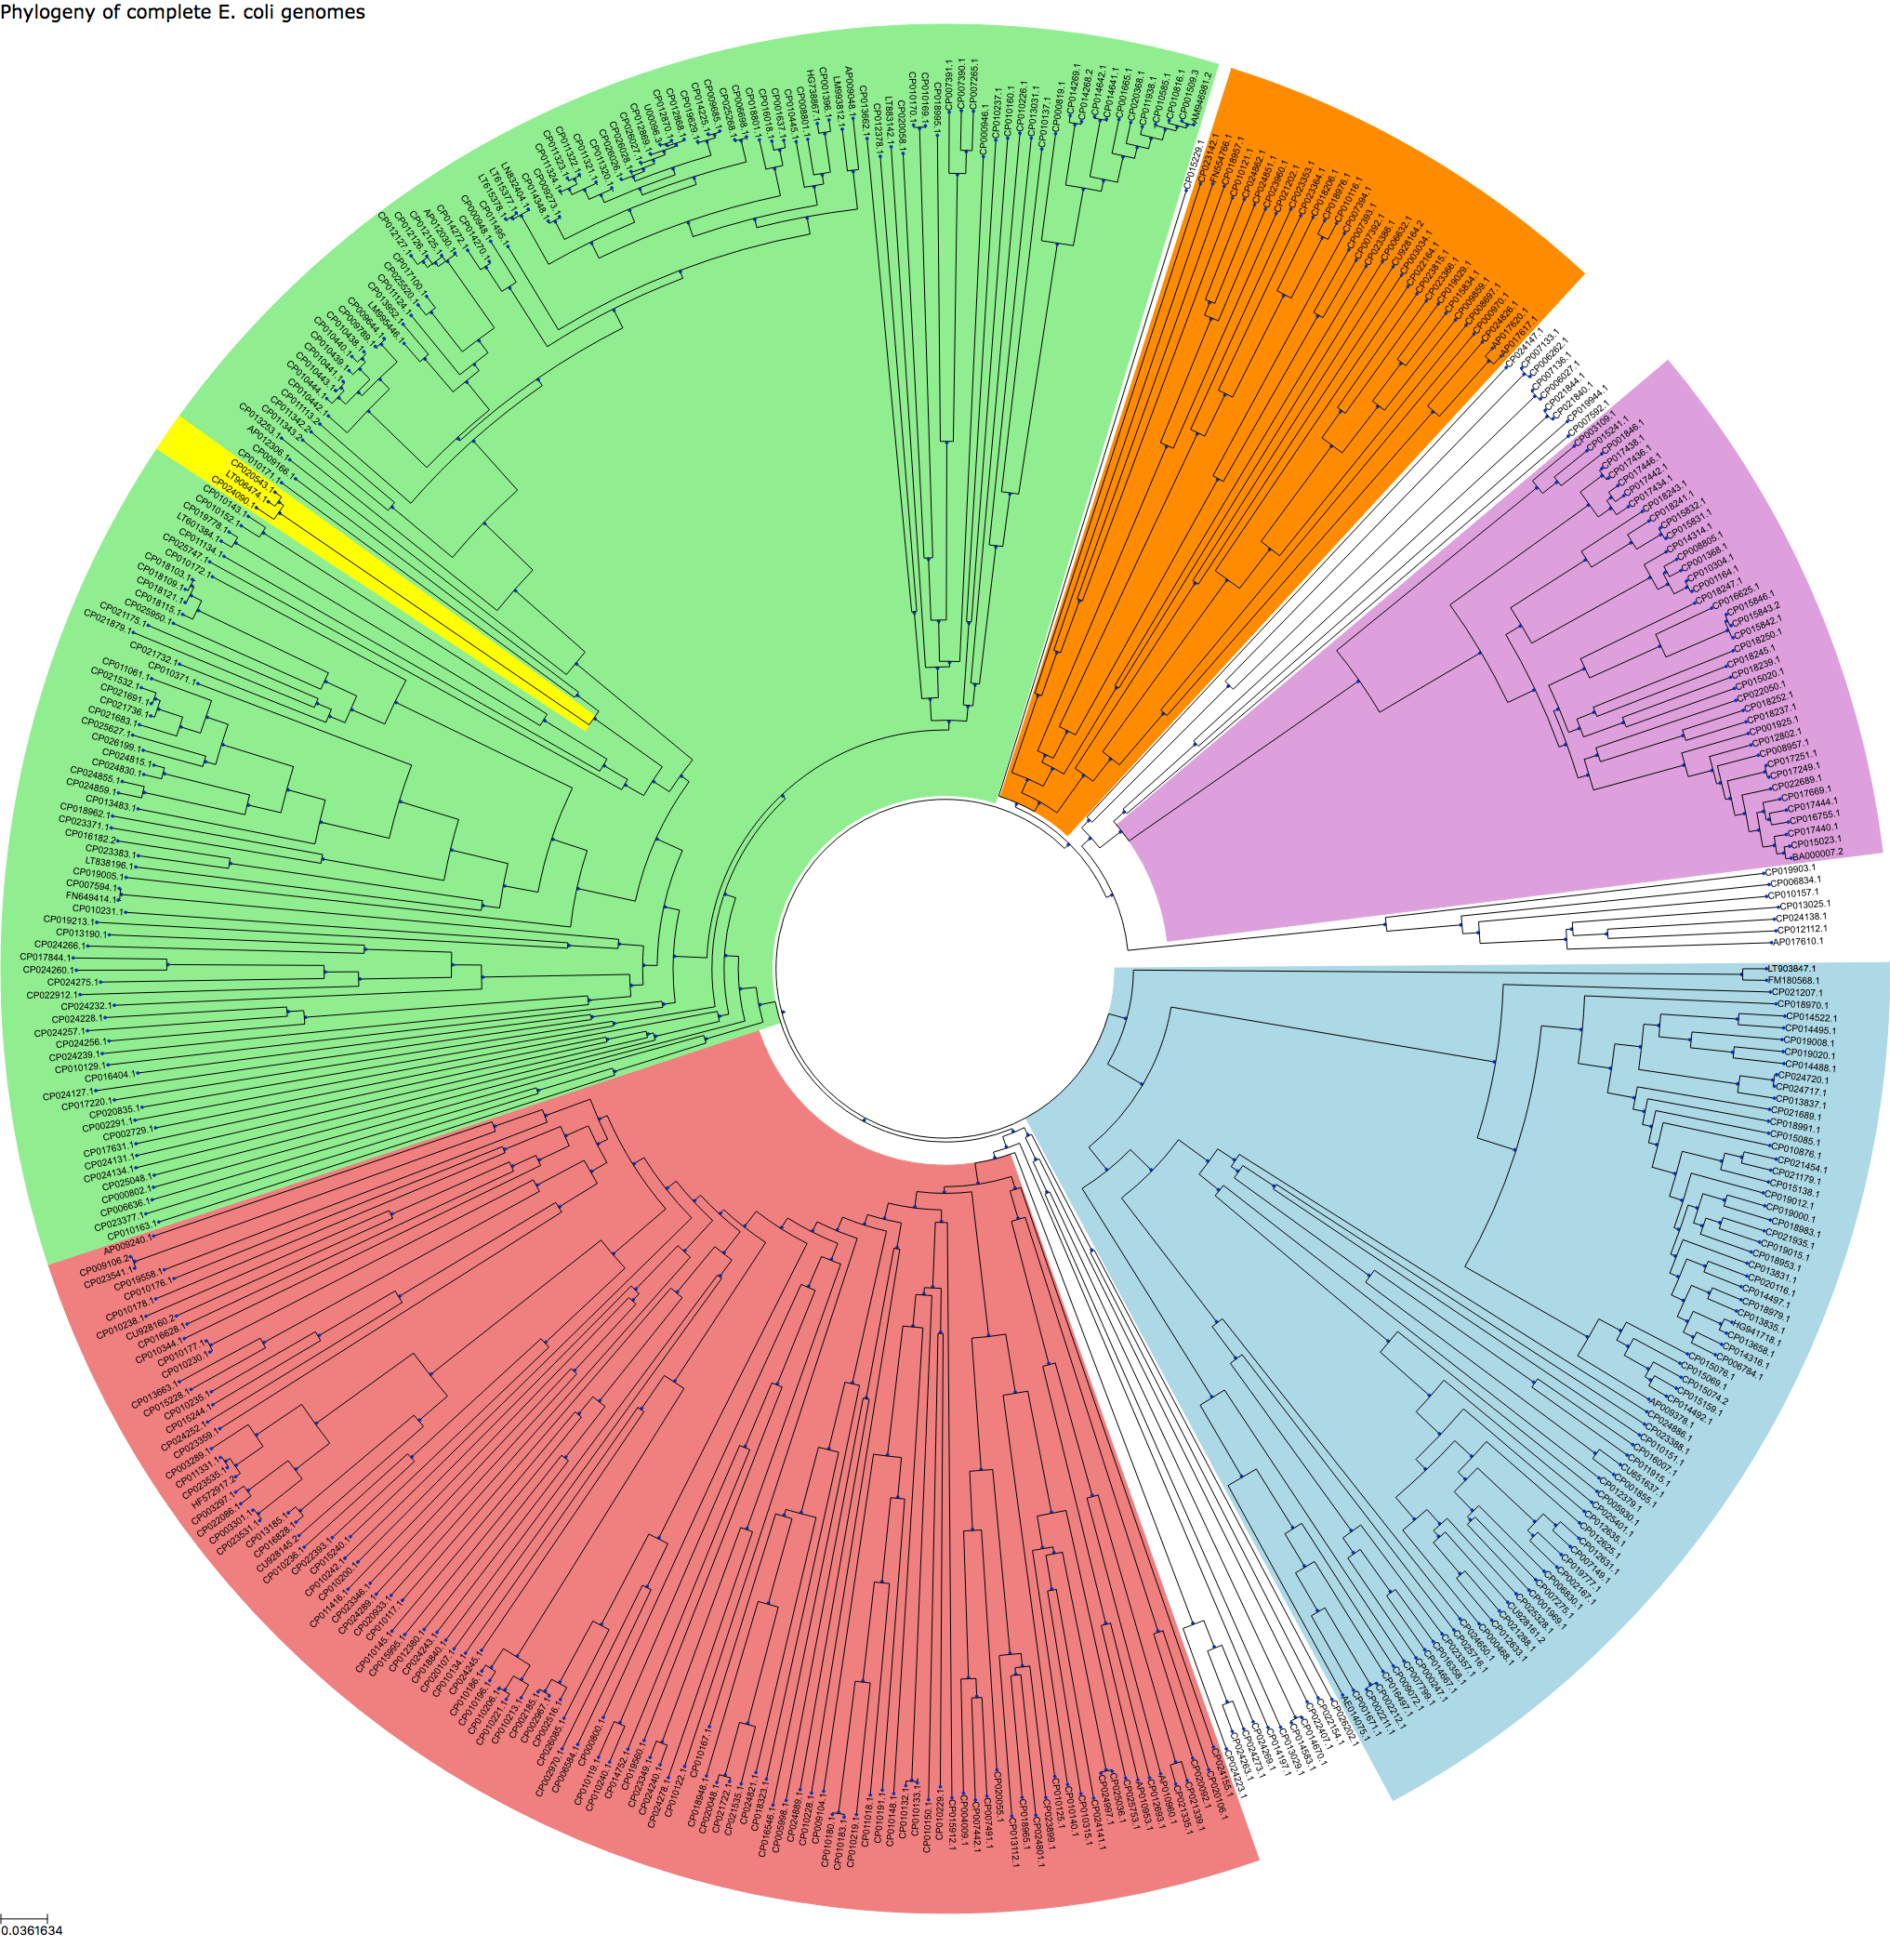

In [46]:
t.render("%%inline", tree_style=ts)